In [2]:
print("Hello World")

Hello World


In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
# fetch_housing_data()

In [6]:
df = load_housing_data()

In [7]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


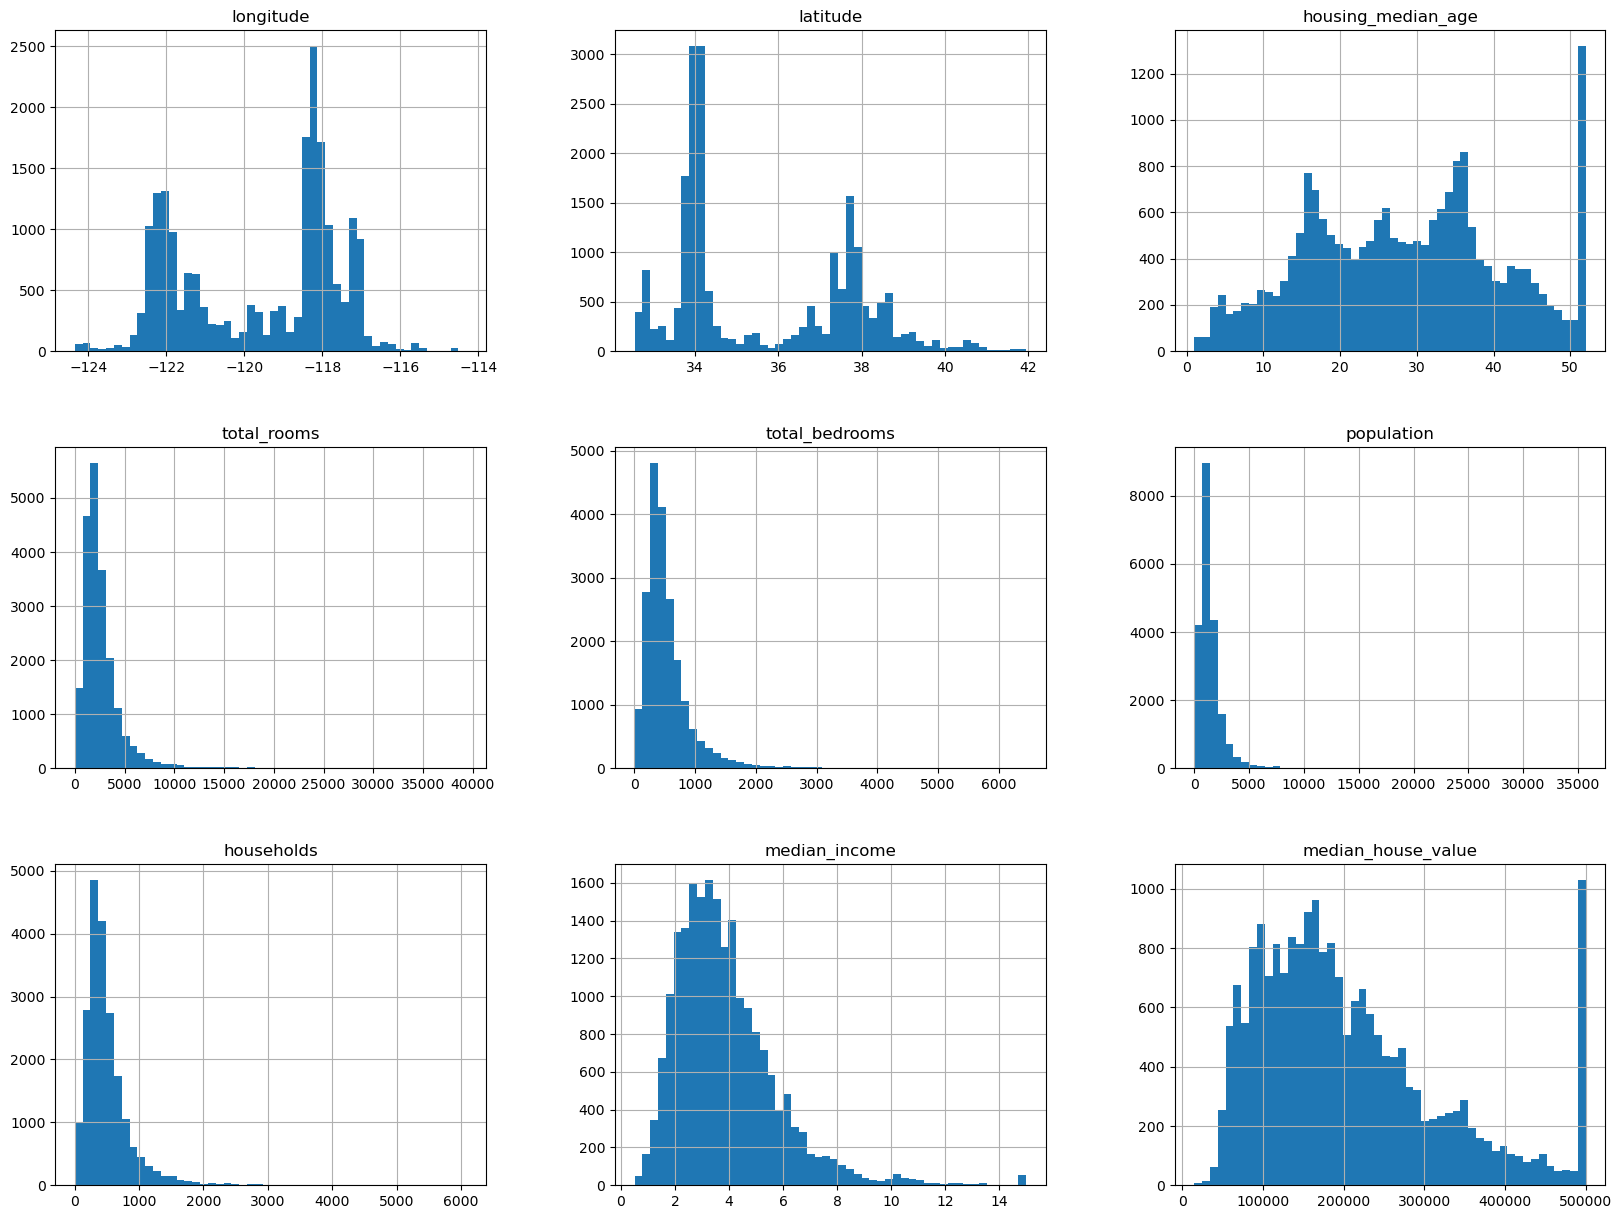

In [11]:
# Only in a Jupyter notebook: Use Jupyter's own backend
%matplotlib inline

import matplotlib.pyplot as plt
df.hist(bins = 50, figsize=(20, 15))
plt.show()

In [12]:
import numpy as np

# BAD in case data gets updated
def split_train_data(df, ratio):
    np.random.seed(56)
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df) * ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return df.iloc[train_indices], df.iloc[test_indices]

In [13]:
from zlib import crc32

def test_set_check(identifier, ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < ratio * 2**32

def split_train_test_by_id(df, ratio, id_column='index'):
    ids = df[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, ratio))
    return df.loc[~in_test_set], df.loc[in_test_set]

In [14]:
# Resetting index to use our new splitting function
# The issue with this is that you need to make sure that new data gets appended to the end of the dataset,
#  and no row ever gets deleted
# housing = df.reset_index()
# train_set, test_set = split_train_test_by_id(housing, 0.2)

# Alternative approach to solve the problem is to use the most stable features as IDs, e.g.:
# housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

# However, the location information is actually quite coarse, and as a result many districts will have the exact same ID, so
#  they will end up in the same set (test or train). This introduces some unfortunate sampling bias.

In [15]:
# Using scikit-learn for splitting
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=36)

In [16]:
len(train_set)

16512

<AxesSubplot: >

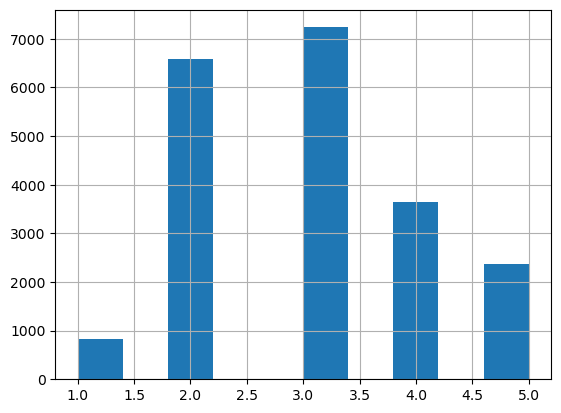

In [17]:
df['income_cat'] = pd.cut(df['median_income'],
                               bins=[0, 1.5, 3, 4.5, 6, np.inf],
                              labels=[1, 2, 3, 4, 5])

df['income_cat'].hist()

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [19]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [20]:
df['income_cat'].value_counts() / len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [22]:
housing = strat_train_set.copy()

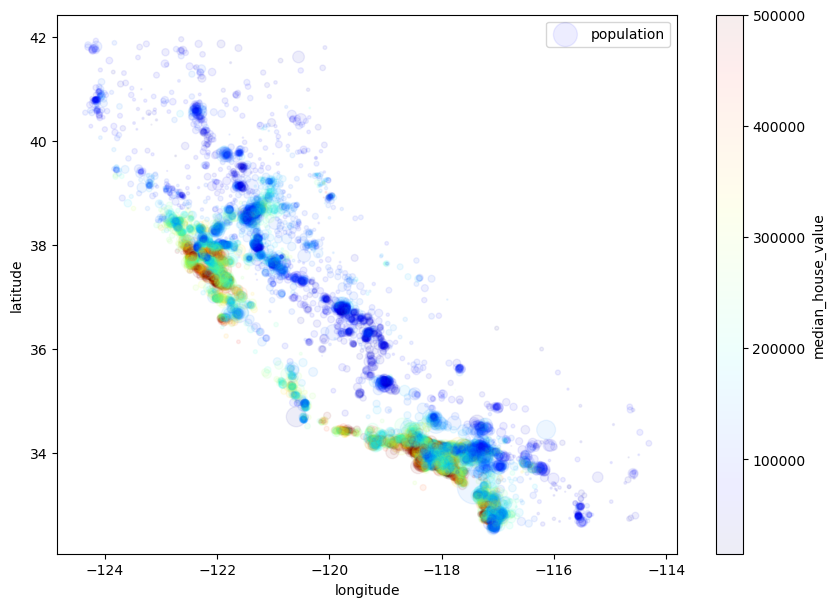

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.07,
            s=housing['population']/60, label='population', figsize=(10, 7),
            c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True)

plt.legend()
plt.show()

In [24]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

/tmp/ipykernel_5153/3704113406.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot: xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot: xlabel

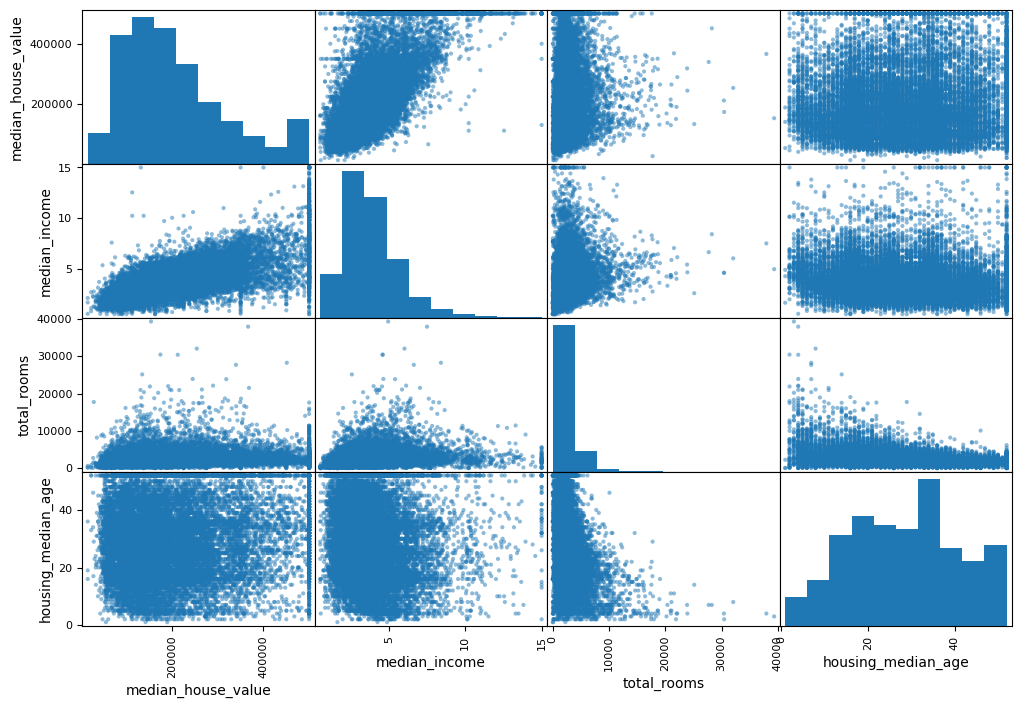

In [25]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))

<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

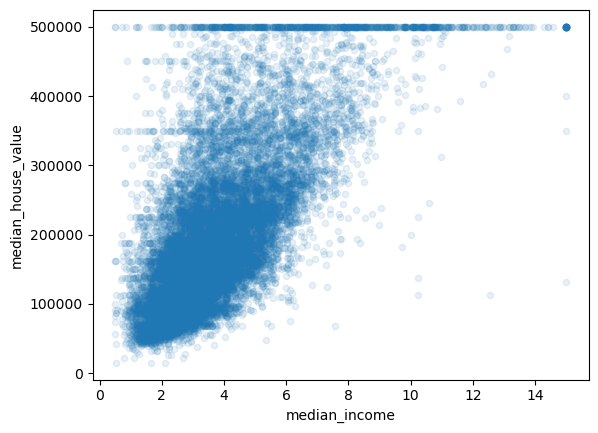

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [27]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_rooms'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [28]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

/tmp/ipykernel_5153/3704113406.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_rooms         -0.259952
Name: median_house_value, dtype: float64

In [29]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [30]:
# Handling missing values
# housing.dropna(subset=["total_bedrooms"]) # option 1
# housing.drop("total_bedrooms", axis=1) # option 2
# median = housing["total_bedrooms"].median() # option 3
# housing["total_bedrooms"].fillna(median, inplace=True)

In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median") # Take care of missing values using replacement with median strategy

housing_num = housing.drop("ocean_proximity", axis=1) # Getting rid of ocean_proximity textual data
imputer.fit(housing_num)

print(imputer.statistics_) # Imputer saves result in its statistics_ instance variable

print(housing_num.median().values)

X = imputer.transform(housing_num) # Use 'trained' imputer to tranform the training set
housing_tr = pd.DataFrame(X, columns=housing_num.columns) # The result is in plane Numpy arrays and should be converted to dataframe
housing_tr.isna().sum()

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

In [32]:
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])

ordinal_encoder.categories_

[[1.]
 [4.]
 [1.]
 [4.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [33]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(cat_encoder.categories_)
print(housing_cat_1hot.toarray())
housing_cat_1hot

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Pipelining using scikit-learn
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [36]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [38]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
np.sqrt(lin_mse)

68627.87390018745

In [38]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [39]:
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
np.sqrt(tree_mse)

0.0

In [40]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [46]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

display_scores(tree_rmse_scores)

NameError: name 'tree_rmse_scores' is not defined

In [42]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818062


In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

forest_reg = RandomForestRegressor()

forest_reg.fit(housing_prepared, housing_labels)

forest_mse = mean_squared_error(housing_labels, housing_predictions)

print(np.sqrt(forest_mse))

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [51544.89505596 48819.91846986 46932.48954584 51687.02157311
 47539.7223408  51506.14266446 52099.61409104 50366.19100914
 48169.94118674 53837.94908796]
Mean: 50250.388502490685
Standard deviation: 2152.9256103896623


In [1]:
# Save model
# You can use Python's pickle module, or:

# from sklearn.externals import joblib
# joblib.dump(my_model, "my_model.pkl")
# my_model_loaded = joblib.load("my_model.pkl")

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [41]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [48]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [49]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64618.62590123324 {'max_features': 2, 'n_estimators': 3}
54862.453504419296 {'max_features': 2, 'n_estimators': 10}
52887.01516613021 {'max_features': 2, 'n_estimators': 30}
60059.6360789871 {'max_features': 4, 'n_estimators': 3}
52604.903375420625 {'max_features': 4, 'n_estimators': 10}
50442.35552154438 {'max_features': 4, 'n_estimators': 30}
58034.78596227246 {'max_features': 6, 'n_estimators': 3}
52596.12356201231 {'max_features': 6, 'n_estimators': 10}
50094.615029800705 {'max_features': 6, 'n_estimators': 30}
59532.31687771524 {'max_features': 8, 'n_estimators': 3}
52153.44675756105 {'max_features': 8, 'n_estimators': 10}
49972.22304125954 {'max_features': 8, 'n_estimators': 30}
61831.762424552726 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54666.80801410266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59163.38600753148 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52425.668651261185 {'bootstrap': False, 'max_features': 3, 'n_estimators'

Notice that we are getting better results with Bootstrap false, notice also that we got the best estimator with the maximum values evaluated.
Let's take those notes into account and perform grid search again

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'bootstrap': [False], 'n_estimators': [30, 50, 100], 'max_features': [8, 10, 12]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [8, 10, 12],
                          'n_estimators': [30, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [55]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 100}

In [56]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49187.20392853834 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
49211.04663414227 {'bootstrap': False, 'max_features': 8, 'n_estimators': 50}
49031.488256315606 {'bootstrap': False, 'max_features': 8, 'n_estimators': 100}
50577.74194898758 {'bootstrap': False, 'max_features': 10, 'n_estimators': 30}
49694.93221451326 {'bootstrap': False, 'max_features': 10, 'n_estimators': 50}
49446.8517491805 {'bootstrap': False, 'max_features': 10, 'n_estimators': 100}
51375.86613537061 {'bootstrap': False, 'max_features': 12, 'n_estimators': 30}
51126.08240069892 {'bootstrap': False, 'max_features': 12, 'n_estimators': 50}
50907.11080288538 {'bootstrap': False, 'max_features': 12, 'n_estimators': 100}


In [59]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.35175063375649857, 'median_income'),
 (0.1605617679788275, 'INLAND'),
 (0.10997897926803685, 'pop_per_hhold'),
 (0.07745083483403174, 'longitude'),
 (0.07201243070844121, 'latitude'),
 (0.06555848225388691, 'bedrooms_per_room'),
 (0.052262750853546765, 'rooms_per_hhold'),
 (0.04219653697288156, 'housing_median_age'),
 (0.014610598564781743, 'total_rooms'),
 (0.014495278482567493, 'population'),
 (0.013974435882989538, 'households'),
 (0.013451732677824589, 'total_bedrooms'),
 (0.006404963349236994, '<1H OCEAN'),
 (0.003141211663545017, 'NEAR OCEAN'),
 (0.002052963422676854, 'NEAR BAY'),
 (9.63993302265332e-05, 'ISLAND')]

In [61]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

46370.706374713074

In [64]:
from scipy import stats
confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([44367.17142425, 48291.18883596])